[[0.   0.   0.   1.  ]
 [0.   0.   0.25 0.75]
 [0.   0.   0.5  0.5 ]
 [0.   0.   0.75 0.25]
 [0.   0.   1.   0.  ]
 [0.   0.25 0.75 0.  ]
 [0.   0.5  0.5  0.  ]
 [0.   0.75 0.25 0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.75 0.   0.  ]
 [0.5  0.5  0.   0.  ]
 [0.75 0.25 0.   0.  ]
 [1.   0.   0.   0.  ]]


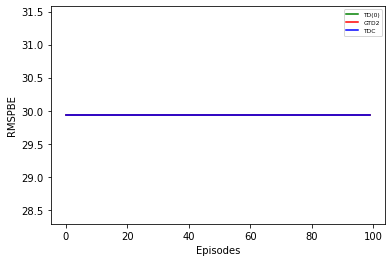

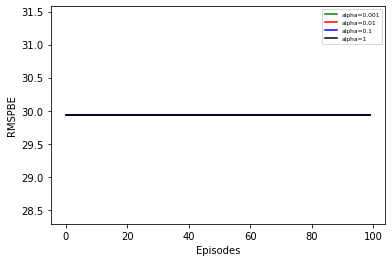

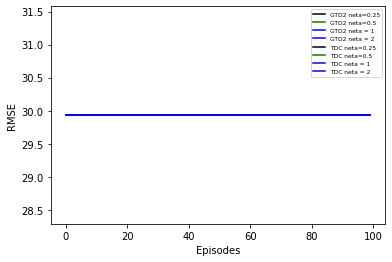

In [12]:
import numpy as np
import sys
import matplotlib.pyplot as pp

np.random.seed(0)

class BoyanChain(object):
    
    def __init__(self, n):
        ''' n is the size of the Boyan Chain. '''
        self.n = n
        self.state = n-1
        self._init_features()
        
    def _init_features(self):
        ''' Initialize the state vector. Right now this only works for the 13-state Boyan chain.'''
        self.features = {}
        
        tmp = [1., 0., 0., 0.]
        state = self.n-1
        ix = 0
        while ix < 3:
            self.features[state] = np.asarray(tmp)
            state -= 1
            tmp[ix] -= 0.25
            tmp[ix+1] += 0.25
            if tmp[ix] == 0: 
                ix += 1
            self.features[0] = np.asarray(tmp)


    def _get_feature(self, state):
        return self.features[state]
    
    def _get_feature_matrix(self):
        self.feature_matrix = np.zeros((self.n,4))
        for i in range(0,self.n):
            self.feature_matrix[i,:] = self.features[i]
        return self.feature_matrix
    
    def reset(self):
        self.state = self.n-1

    def step(self):
        ''' Return the next state. 
            Return None if episode is over (reached state 0).
            Otherwise return a reward and the feature for the next state.
        '''
        if self.state >= 2:
            if np.random.uniform() > 0.5:
                self.state, reward = self.state - 2, -3.
        else:
            self.state, reward = self.state - 1, -3.
        if self.state == 1:
            self.state, reward = self.state - 1, -2.
        else:
            return (None, None)

        return (self._get_feature(self.state), reward)

    def get_transition_matrix(self):
        self.transition_matrix = np.zeros((self.n,self.n),dtype = np.float32)
        for i in range(2,12):
            self.transition_matrix[i,i-1] = 0.5
            self.transition_matrix[i,i-2] = 0.5
        self.transition_matrix[1,0] = 1
        self.transition_matrix[0,0] = 1
        
    def get_stationary_dist(self):
        pass
    
class TD(object):
    def __init__(self, dim, gamma, alpha):
        self.theta = np.zeros((dim,))
        self.gamma = gamma
        self.alpha = alpha

    def update(self, s, sp1, r):
        d = (r + self.gamma* np.dot(self.theta, sp1) - np.dot(self.theta, s))
        self.theta = self.theta + self.alpha*d*s

    def get_theta(self):
        return self.theta

class GTD2(object):
    
    def __init__(self, dim, gamma, alpha,neta):
        self.theta = np.zeros((dim,))
        self.w = np.zeros((dim,))
        self.gamma = gamma
        self.alpha = alpha
        self.neta = neta

    def update(self, s, sp1, r):
        theta_update = np.dot(self.w,s)*(s - self.gamma*sp1)
        delta = (r + self.gamma* np.dot(self.theta, sp1) - np.dot(self.theta, s))
        w_update = (delta - np.dot(self.w,s))*s
        self.theta = self.theta + self.alpha*theta_update
        self.w = self.w + self.neta*self.alpha*w_update
        
    def get_theta(self):
        return self.theta
    
class TDC(object):
    
    def __init__(self, dim, gamma, alpha,neta):
        self.theta = np.zeros((dim,))
        self.w = np.zeros((dim,))
        self.gamma = gamma
        self.alpha = alpha
        self.neta = neta

    def update(self, s, sp1, r):
        delta = (r + self.gamma* np.dot(self.theta, sp1) - np.dot(self.theta, s))
        w_update = (delta - np.dot(self.w,s))*s
        theta_update = delta*s - self.gamma*np.dot(self.w,s)*sp1
        self.theta = self.theta + self.alpha*theta_update
        self.w = self.w + self.neta*self.alpha*w_update

    def get_theta(self):
        return self.theta
    
def RMSPBE(x, y):
    return np.sqrt(np.sum((x-y)**2))

N_EPS = 100
N_TRIALS = 100

FONT_SIZE=6
if __name__ == '__main__':
    
    boyan = BoyanChain(13)
    phi = boyan._get_feature_matrix()
    print(phi)
    estimates = {'td':np.zeros((N_TRIALS, N_EPS)), 'gtd2':np.zeros((N_TRIALS, N_EPS)), 'tdc':np.zeros((N_TRIALS, N_EPS))}
    for t_ix in range(0, N_TRIALS):
        #lstd = LSTD(4, 1.)
        #rlstd = RLSTD(4, 1., 5)
        #lstd_lam = LSTD_lam(4, 1., 1.)
        td = TD(4, 1., 0.05)
        gtd2 = GTD2(4,1.,0.05,0.25)
        tdc = TDC(4,1.,0.05,0.25)
        true_theta = np.asarray([-24., -16., -8., 0.])
        for ep_ix in range(0, N_EPS):
            boyan.reset()
            prev_state, state = boyan._get_feature(boyan.state), None
            # Execute an episode.
            while True:
                state, reward = boyan.step()
                if state is None:
                    break
                # Update each algorithms estimates.
                td.update(prev_state, state, reward)
                gtd2.update(prev_state, state, reward)
                tdc.update(prev_state, state, reward)
                prev_state = state
            estimates['td'][t_ix, ep_ix] = RMSPBE(true_theta, td.get_theta())
            estimates['gtd2'][t_ix, ep_ix] = RMSPBE(true_theta, gtd2.get_theta())
            estimates['tdc'][t_ix, ep_ix] = RMSPBE(true_theta, tdc.get_theta())

    line_td, = pp.plot(range(0, N_EPS), np.mean(estimates['td'], axis=0), 'g-', label='TD(0)')
    line_gtd2, = pp.plot(range(0, N_EPS), np.mean(estimates['gtd2'], axis=0), 'r-', label='GTD2')
    line_tdc, = pp.plot(range(0, N_EPS), np.mean(estimates['tdc'], axis=0), 'b-', label='TDC')
    pp.ylabel("RMSPBE")
    pp.xlabel("Episodes")
    pp.legend(handles=[line_td, line_gtd2, line_tdc], prop={'size':FONT_SIZE})
    pp.show()
    # Choose different step-sizes for TD(0).
    estimates = {}
    for alpha in [0.001, 0.01, 0.1, 1.]:
        td = TD(4, 1, alpha)
        estimates[alpha] = []

        for ep in range(0, N_EPS):
            #print ('Episode: %d' % ep)
            boyan.reset()

            prev_state, state = boyan._get_feature(boyan.state), None
            while True:
                state, reward = boyan.step()
                if state is None:
                    break
                td.update(prev_state, state, reward)
                prev_state = state
            estimates[alpha].append(RMSPBE(true_theta, td.get_theta()))


    line1, = pp.plot(range(0, N_EPS), estimates[0.001], 'g-', label='alpha=0.001')
    line2, = pp.plot(range(0, N_EPS), estimates[0.01], 'r-', label='alpha=0.01')
    line3, = pp.plot(range(0, N_EPS), estimates[0.1], 'b-', label='alpha=0.1')
    line4, = pp.plot(range(0, N_EPS), estimates[1.], 'k-', label='alpha=1')
    pp.ylabel("RMSPBE")
    pp.xlabel("Episodes")

    pp.legend(handles=[line1, line2, line3, line4], prop={'size':FONT_SIZE})
    pp.show()

    # Choose different neta for GTD2 and TDC.
    estimates_gtd2 = {}
    estimates_tdc = {}
    for neta in [1/4, 1/2, 1, 2 ]:
        gtd2 = GTD2(4, 1, 0.05,neta)
        tdc = TDC(4, 1, 0.05,neta)
        estimates_gtd2[neta] = []
        estimates_tdc[neta] = []
        
        for ep in range(0, N_EPS):
            #print ('Episode: %d' % ep)
            boyan.reset()
            prev_state, state = boyan._get_feature(boyan.state), None
            while True:
                state, reward = boyan.step()
                if state is None:
                    break
                gtd2.update(prev_state, state, reward)
                tdc.update(prev_state, state, reward)
                prev_state = state
            estimates_gtd2[neta].append(RMSPBE(true_theta, gtd2.get_theta()))
            estimates_tdc[neta].append(RMSPBE(true_theta, tdc.get_theta()))

    line1, = pp.plot(range(0, N_EPS), estimates_gtd2[1/4], 'k-', label='GTD2 neta=0.25')
    line2, = pp.plot(range(0, N_EPS), estimates_gtd2[1/2], 'g-', label='GTD2 neta=0.5')
    line3, = pp.plot(range(0, N_EPS), estimates_gtd2[1], 'b-', label='GTD2 neta = 1')
    line4, = pp.plot(range(0, N_EPS), estimates_gtd2[2], 'b-', label='GTD2 neta = 2')
    line5, = pp.plot(range(0, N_EPS), estimates_tdc[1/4], 'k-', label='TDC neta=0.25')
    line6, = pp.plot(range(0, N_EPS), estimates_tdc[1/2], 'g-', label='TDC neta=0.5')
    line7, = pp.plot(range(0, N_EPS), estimates_tdc[1], 'b-', label='TDC neta = 1')
    line8, = pp.plot(range(0, N_EPS), estimates_tdc[2], 'b-', label='TDC neta = 2')
    pp.legend(handles=[line1, line2, line3,line4, line5, line6,line7, line8], prop={'size':FONT_SIZE})
    pp.ylabel("RMSE")
    pp.xlabel("Episodes")
    pp.show()

